In [2]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
nltk.download('punkt')

data = pd.read_csv("data/data-filtered.csv")
df = pd.DataFrame(data=data)
df.columns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\miq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [3]:
df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [4]:
df[df['author']=='GallowBoob']

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
480356,0,g to the boob,GallowBoob,casualiama,3,3,0,2015-08,2015-08-05 23:49:46,Why is the G like that? Are you geriatric?
488412,1,no it does not,GallowBoob,OutOfTheLoop,52,52,0,2015-07,2015-07-03 01:21:53,Does Reddit even have power users?
581258,1,Pls don't fire me over this reddit!,GallowBoob,PerfectTiming,61,61,0,2015-07,2015-07-31 14:00:32,"Well, I think you are allowed to make a mistak..."
707627,0,**I AM PREGGIT**,GallowBoob,GallowBoob,-4,-4,0,2015-05,2015-05-25 14:12:57,^


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

C:\Users\miq\Miniconda3\envs\Py3_ICNS\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [8]:
def find_features(row): #extracts features from comment text only
    comment = row['comment']
    features = sid.polarity_scores(comment) #sentiment features
    
    #unigrams and bigrams to features
    stemmer = nltk.PorterStemmer()
    words = nltk.word_tokenize(comment)
    words = [stemmer.stem(w.lower()) for w in words]
    
    bigrams = nltk.bigrams(words)
    bigrams = [t[0]+' '+t[1] for t in bigrams]
    
    for w in words:
        features['contains({})'.format(w)] = 1.0
    for b in bigrams:
        features['contains({})'.format(w)] = 1.0
    
    return features

def find_features2(row): #added parent comment sentiment, subreddit, upvotes, downvotes and comment score
    features = find_features(row)
    
    #parent comment sentiment
    parent_sent = sid.polarity_scores(row['parent_comment'])
    for key, value in parent_sent.items():
        features['parent_{}'.format(key)]=value
        
    #meta-info to features
    features['subreddit'] = row['subreddit']
    features['score'] = row['score'] 
    features['ups'] = row['ups']
    features['downs'] = row['downs']
    
    return features
        
    

In [9]:
comment_features = []
all_features = []

#fills two lists with feature dictionaries
for index, row in df.iterrows():
    comment_features.append(find_features(row))
    all_features.append(find_features2(row))

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

v = DictVectorizer()

f_vector1 = v.fit_transform(comment_features)
f_vector2 = v.fit_transform(all_features)

labels = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(f_vector1, labels, test_size=0.3, random_state=42)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(f_vector2, labels, test_size=0.3, random_state=42)

In [74]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    svc = LinearSVC(penalty='l2',dual=False,class_weight='balanced',max_iter=10000)
    grid_search = GridSearchCV(svc, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [76]:
#train svc model with comment features
svc1 = LinearSVC(C=0.1,penalty='l2',dual=False,class_weight='balanced')
svc1.fit(X_train,y_train)

LinearSVC(C=0.1, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [78]:
svc1_result = svc1.predict(X_test)
print(classification_report(y_test, svc1_result))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70    132989
           1       0.73      0.68      0.70    142597

   micro avg       0.70      0.70      0.70    275586
   macro avg       0.70      0.70      0.70    275586
weighted avg       0.70      0.70      0.70    275586



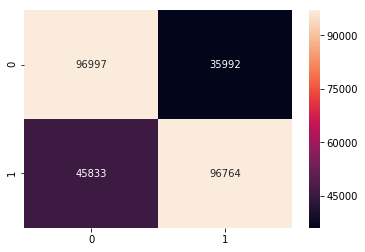

In [79]:
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix
cm = confusion_matrix(y_test,svc1.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [13]:
#train svc model with all features
svc2 = LinearSVC(C=0.1,penalty='l2',dual=False,class_weight='balanced')
svc2.fit(X_train_all,y_train_all)

LinearSVC(C=0.1, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [14]:
svc2_result = svc2.predict(X_test_all)
print(classification_report(y_test_all, svc2_result))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71    132989
           1       0.73      0.69      0.71    142597

   micro avg       0.71      0.71      0.71    275586
   macro avg       0.71      0.71      0.71    275586
weighted avg       0.71      0.71      0.71    275586



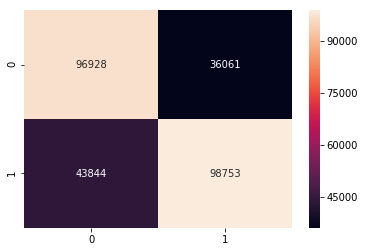

In [77]:
cm = confusion_matrix(y_test,svc2.predict(X_test_all))
sns.heatmap(cm,annot=True,fmt="d")

In [66]:
from sklearn.naive_bayes import BernoulliNB

clf1 = BernoulliNB()
clf1.fit(X_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [65]:
clf1_result = clf1.predict(X_test)
print(classification_report(y_test, clf1_result))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66    132989
           1       0.69      0.72      0.70    142597

   micro avg       0.68      0.68      0.68    275586
   macro avg       0.68      0.68      0.68    275586
weighted avg       0.68      0.68      0.68    275586



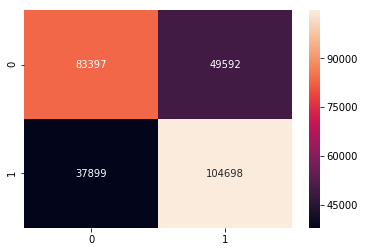

In [63]:
cm = confusion_matrix(y_test,clf1.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

              precision    recall  f1-score   support

           0       0.70      0.64      0.67    132989
           1       0.69      0.74      0.71    142597

   micro avg       0.69      0.69      0.69    275586
   macro avg       0.69      0.69      0.69    275586
weighted avg       0.69      0.69      0.69    275586



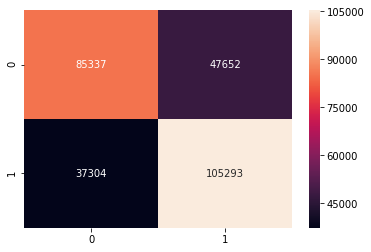

In [80]:
clf2 = BernoulliNB()
clf2.fit(X_train_all,y_train_all)

clf2_result = clf2.predict(X_test_all)
print(classification_report(y_test_all, clf2_result))

cm = confusion_matrix(y_test_all,clf2.predict(X_test_all))
sns.heatmap(cm,annot=True,fmt="d")